# Example for training Spiking CNN on subset of NMNIST digits

## The problem:
Training digit classifier(0-9) on a subset(1000 training and 100 testing) of NMNIST digit spikes recorded using DVS camera. Just chagne the training list to for full NMNIST training.

## Load proper paths for SLAYER Pytorch source modules

In [1]:
import sys, os
DATA_DIR = '../data'
sys.path.append('../slayerPytorch/src')

## Load required modules

SLAYER modules are available as `snn`
* The `spike-layer` module will be available as `snn.layer`.
* The `yaml-parameter` module will be availabe as `snn.params`.
* The `spike-loss` module will be available as `snn.loss`.
* The `spike-classifier` module will be available as `snn.predict`.
* The `spike-IO` module will be available as `snn.io`.


In [2]:
from datetime import datetime
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from learningStats import learningStats
from IPython.display import HTML
import zipfile
from torch.utils.tensorboard import SummaryWriter
import torchvision

## Read SNN configuration from yaml file
See the file for all the configuration parameters. This configuration file will be used to describe the SNN. We will ignore the network configuration  describe in the yaml file here.

In [3]:
netParams = snn.params('../network-moredata.yaml')

In [4]:
netParams['training']

{'error': {'type': 'NumSpikes',
  'probSlidingWin': 20,
  'tgtSpikeRegion': {'start': 0, 'stop': 300},
  'tgtSpikeCount': {True: 60, False: 10}},
 'path': {'train': {'data': 'NMNIST/Train',
   'labels': 'NMNIST/Train/labels.txt'},
  'test': {'data': 'NMNIST/Test', 'labels': 'NMNIST/Test/labels.txt'}}}

## MNIST and MNIST->MNIST datasets

In [5]:
trainMNIST = torchvision.datasets.MNIST(
    root=os.path.join(DATA_DIR,'MNIST'),
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor())

In [6]:
testMNIST = torchvision.datasets.MNIST(
    root=os.path.join(DATA_DIR,'MNIST'),
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor())

In [7]:
# Dataset definition
class NMNIST_MNIST(Dataset):
    def __init__(self, MNIST, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = os.path.join(DATA_DIR, datasetPath)
        self.samples = np.loadtxt(os.path.join(DATA_DIR, sampleFile)).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)
        self.MNIST = MNIST

    def __getitem__(self, index):
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]

        inputSpikes = snn.io.read2Dspikes(
                        os.path.join(self.path, str(classLabel), format(inputIndex.item(), '05d') + '.bin')
                        ).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
                        samplingTime=self.samplingTime)
#         sparseInputSpikes = torch.sparse_coo_tensor([inputSpikes.p, inputSpikes.y, inputSpikes.x, inputSpikes.t],
#                                                         np.ones_like(inputSpikes.p), (2, 34, 34, 306))

#         desiredClass = torch.zeros((10, 1, 1, 1))
#         desiredClass[classLabel,...] = 1
        return inputSpikes, self.MNIST[inputIndex-1][0].unsqueeze(-1)

    def __len__(self):
        return self.samples.shape[0]

In [8]:
trainNMNIST = NMNIST_MNIST(trainMNIST,
                           datasetPath =netParams['training']['path']['train']['data'], 
                            sampleFile  =netParams['training']['path']['train']['labels'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])

In [9]:
testNMNIST = NMNIST_MNIST(testMNIST,
                          datasetPath =netParams['training']['path']['test']['data'], 
                            sampleFile  =netParams['training']['path']['test']['labels'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])

## Visualize the spike data

In [10]:
spikes, image = testNMNIST[5234]
anim = snn.io.animTD(snn.io.spikeArrayToEvent(spikes.reshape((2, 34, 34, -1)).cpu().data.numpy()))
# anim = snn.io.animTD(snn.io.spikeArrayToEvent(input.to_dense().reshape((2, 34, 34, -1)).cpu().data.numpy()))
HTML(anim.to_jshtml())

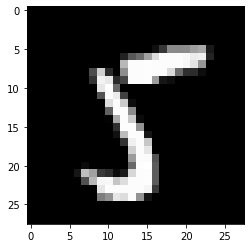

In [11]:
plt.imshow(image.numpy()[0,:,:,0], cmap='gray')

## Noisy data

In [12]:
# Delete the rogue temp-file
try:
    os.remove('None0000000.png')
except FileNotFoundError:
    pass

In [13]:
# Define the cuda device to run the code on.
# device = torch.device('cuda')
# Use multiple GPU's if available
device = torch.device('cuda:0')#:2') # should be the first GPU of deviceIDs 
deviceIds = [0]#2, 3]

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [14]:
class SpikeToImageNet(torch.nn.Module):
    def __init__(self, netParams=netParams):
        super(SpikeToImageNet, self).__init__()
         # initialize slayer
        self.slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        
        # Create snn loss instance.
        self.error = snn.loss(netParams).to(device)
        
        # define layers
        self.conv1 = self.slayer.conv(2, 10, 5, padding=1)
        self.conv2 = self.slayer.conv(10, 10, 3, padding=1)
        self.conv3 = self.slayer.conv(10, 5, 3)
        self.conv4 = self.slayer.conv(5, 1, 3)
        
    def forward(self, x):
        x = self.slayer.spike(self.conv1(self.slayer.psp(x)))
        x = self.slayer.spike(self.conv2(self.slayer.psp(x)))
        x = self.slayer.spike(self.conv3(self.slayer.psp(x)))
        x = self.slayer.spike(self.conv4(self.slayer.psp(x)))
        return x

# create instance of network, dataloaders, and optimizer

In [15]:
def numSpikesAnalog(self, spikeOut, desiredSpikes, numSpikesScale=1):
        '''
        Calculates spike loss based on number of spikes within a `target region`.
        The `target region` and `desired spike count` is specified in ``error.errorDescriptor['tgtSpikeRegion']``
        Any spikes outside the target region are penalized with ``error.spikeTime`` loss..

        .. math::
            e(t) &= 
            \\begin{cases}
            \\frac{acutalSpikeCount - desiredSpikeCount}{targetRegionLength} & \\text{for }t \in targetRegion\\\\
            \\left(\\varepsilon * (output - desired)\\right)(t) & \\text{otherwise}
            \\end{cases}
            
            E &= \\int_0^T e(t)^2 \\text{d}t

        Arguments:
            * ``spikeOut`` (``torch.tensor``): spike tensor
            * ``desiredClass`` (``torch.tensor``): one-hot encoded desired class tensor. Time dimension should be 1 and rest of the tensor dimensions should be same as ``spikeOut``.

        Usage:

        >>> loss = error.numSpikes(spikeOut, target)
        '''
        # Tested with autograd, it works
        assert self.errorDescriptor['type'] == 'NumSpikes', "Error type is not NumSpikes"
        # desiredClass should be one-hot tensor with 5th dimension 1
        tgtSpikeRegion = self.errorDescriptor['tgtSpikeRegion']
        tgtSpikeCount  = self.errorDescriptor['tgtSpikeCount']
        startID = np.rint( tgtSpikeRegion['start'] / self.simulation['Ts'] ).astype(int)
        stopID  = np.rint( tgtSpikeRegion['stop' ] / self.simulation['Ts'] ).astype(int)
        
        actualSpikes = torch.sigmoid(torch.sum(spikeOut[...,startID:stopID], 4, keepdim=True)/10-3.5)\
                            .cpu().detach().numpy() * self.simulation['Ts']
        # MNIST uses values from 0 to 1. Dividing by 10 and subtracting 3.5 then taking the sigmoid means
        # the center of the sigmoid will occur at around 35 spikes, and it will reach over 90% by 60 spikes,
        # and less than 10% by less than 10 spikes.
        
        # desiredSpikes = np.where(desiredClass.cpu() == True, tgtSpikeCount[True], tgtSpikeCount[False])
        desiredSpikes = desiredSpikes.cpu().numpy()
        # print('actualSpikes :', actualSpikes.flatten())
        # print('desiredSpikes:', desiredSpikes.flatten())
#         print(actualSpikes.shape, desiredSpikes.shape)
        errorSpikeCount = (actualSpikes - desiredSpikes) / (stopID - startID) * numSpikesScale
#         print(errorSpikeCount.shape)
        targetRegion = np.zeros(spikeOut.shape)
        targetRegion[:,:,:,:,startID:stopID] = 1;
        spikeDesired = torch.FloatTensor(targetRegion * spikeOut.cpu().data.numpy()).to(spikeOut.device)
        
        # error = self.psp(spikeOut - spikeDesired)
        error = self.slayer.psp(spikeOut - spikeDesired)
        error += torch.FloatTensor(errorSpikeCount * targetRegion).to(spikeOut.device)
        
        return 1/2 * torch.sum(error**2) * self.simulation['Ts']

In [16]:
def numSpikesAnalogActivation(self, spikeOut, desiredActivation, numSpikesScale=1):
        '''
        Calculates spike loss based on number of spikes within a `target region`.
        The `target region` and `desired spike count` is specified in ``error.errorDescriptor['tgtSpikeRegion']``
        Any spikes outside the target region are penalized with ``error.spikeTime`` loss..

        .. math::
            e(t) &= 
            \\begin{cases}
            \\frac{acutalSpikeCount - desiredSpikeCount}{targetRegionLength} & \\text{for }t \in targetRegion\\\\
            \\left(\\varepsilon * (output - desired)\\right)(t) & \\text{otherwise}
            \\end{cases}
            
            E &= \\int_0^T e(t)^2 \\text{d}t

        Arguments:
            * ``spikeOut`` (``torch.tensor``): spike tensor
            * ``desiredClass`` (``torch.tensor``): one-hot encoded desired class tensor. Time dimension should be 1 and rest of the tensor dimensions should be same as ``spikeOut``.

        Usage:

        >>> loss = error.numSpikes(spikeOut, target)
        '''
        # Tested with autograd, it works
        assert self.errorDescriptor['type'] == 'NumSpikes', "Error type is not NumSpikes"
        # desiredClass should be one-hot tensor with 5th dimension 1
        tgtSpikeRegion = self.errorDescriptor['tgtSpikeRegion']
        tgtSpikeCount  = self.errorDescriptor['tgtSpikeCount']
        startID = np.rint( tgtSpikeRegion['start'] / self.simulation['Ts'] ).astype(int)
        stopID  = np.rint( tgtSpikeRegion['stop' ] / self.simulation['Ts'] ).astype(int)
        
        actualSpikes = torch.sum(spikeOut[...,startID:stopID], 4, keepdim=True)\
                            .cpu().detach().numpy() * self.simulation['Ts']
        # MNIST uses values from 0 to 1. Dividing by 10 and subtracting 3.5 then taking the sigmoid means
        # the center of the sigmoid will occur at around 35 spikes, and it will reach over 90% by 60 spikes,
        # and less than 10% by less than 10 spikes.
        
        # desiredSpikes = np.where(desiredClass.cpu() == True, tgtSpikeCount[True], tgtSpikeCount[False])
        desiredSpikes = desiredActivation.cpu().numpy() \
                            * (tgtSpikeCount[True]-tgtSpikeCount[False]) + tgtSpikeCount[False]
        # print('actualSpikes :', actualSpikes.flatten())
        # print('desiredSpikes:', desiredSpikes.flatten())
#         print(actualSpikes.shape, desiredSpikes.shape)
        errorSpikeCount = np.abs(actualSpikes - desiredSpikes) / (stopID - startID) * numSpikesScale
#         print(errorSpikeCount.shape)
        targetRegion = np.zeros(spikeOut.shape)
        targetRegion[:,:,:,:,startID:stopID] = 1;
        spikeDesired = torch.FloatTensor(targetRegion * spikeOut.cpu().data.numpy()).to(spikeOut.device)
        
        # error = self.psp(spikeOut - spikeDesired)
        error = self.slayer.psp(spikeOut - spikeDesired)
        error += torch.FloatTensor(errorSpikeCount * targetRegion).to(spikeOut.device)
        
        return 1/2 * torch.sum(error**2) * self.simulation['Ts']

In [17]:
# Instantiate network
net = SpikeToImageNet()
device = torch.device("cuda:0") # for training on GPU
net = net.to(device) # move it to device

# Dataset and dataLoader instances.
trainingSet = trainNMNIST
trainingsubset = torch.LongTensor(6000).random_(0, len(trainingSet))
trainLoader = DataLoader(dataset=trainingSet, batch_size=8, # shuffle=True,
                         sampler=torch.utils.data.SubsetRandomSampler(trainingsubset),
                         num_workers=4)

testingSet = testNMNIST
testingsubset = torch.LongTensor(10).random_(0, len(testingSet))
testLoader = DataLoader(dataset=testingSet, batch_size=10, # shuffle=True, 
                        sampler=torch.utils.data.SubsetRandomSampler(testingsubset),
                        num_workers=4)

# Set the loss function
error = snn.loss(netParams).to(device)

# Define optimizer module.
optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)

# Train it!

In [32]:
i = 0
while os.path.exists(os.path.join('tensorboard', format(i, '03'))): i+=1
logdir = os.path.join('tensorboard', format(i, '03'))

# Create writer for logging to tensorboard
writer = SummaryWriter(logdir)

# epoch loop.
for epoch in tqdm.trange(100, desc='epochs'):
        # Reset training stats.
#         stats.training.reset()
#         tSt = datetime.now()
#         trainCorrectSamples = 0
#         trainNumSamples = 0
        trainLoss = 0
        # Training loop.
        for i, (spikes, image) in enumerate(tqdm.tqdm(trainLoader, desc='training loop', leave=False), 0):
            # Move the input and target to correct GPU.
            spikes = spikes.to(device)
            image  = image.to(device)

            # Forward pass of the network.
            output = net.forward(spikes)

            # Gather the training stats.
#             trainCorrectSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
#             trainNumSamples     += len(label)

            # Calculate loss.
            loss = numSpikesAnalog(error, output, image)

            # Reset gradients to zero.
            optimizer.zero_grad()

            # Backward pass of the network.
            loss.backward()

            # Update weights.
            optimizer.step()

            # Gather training loss stats.
            trainLoss += loss.cpu().data.item()

            # Display training stats. (Suitable for normal python implementation)
#             stats.print(epoch, i, (datetime.now() - tSt).total_seconds())
            
            if i%300 == 0:
                # Update training stats.
#                 try: stats.training.update()
#                 except TypeError: print('train acc should be 0', TypeError)
                # Reset testing stats.
#                 stats.testing.reset()
                
                testLoss = 0
                
                # Testing loop.
                # Same steps as Training loops except loss backpropagation and weight update.
                
#                 for i, (spikes, image) in tqdm.tqdm(enumerate(testLoader, 0), desc='testing loop', leave=False):
                spikes, image = next(iter(trainLoader))
                spikes = spikes.to(device)
                output = net.forward(spikes)

#                 testCorrectSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
#                 testNumSamples     += len(label)

                loss = numSpikesAnalog(error, output, image)
                testLoss += loss.cpu().data.item()

                # display sample output in tensorboard
                spikegrid = torchvision.utils.make_grid(output.sum(dim=4)) # output spikes summed in time
                mnistgrid = torchvision.utils.make_grid(image.squeeze(dim=4)) # all mnist images in the batch
                
                step = int( (epoch*len(trainLoader) + i) / 300 )
                writer.add_image('Total spikes',   spikegrid, step)
                writer.add_image('MNIST refrence', mnistgrid, step)
                writer.add_scalar('Loss/train',    trainLoss, step)
                writer.add_scalar('Loss/test',     testLoss,  step)
#                 stats.print(epoch, i)

                # Reset training stats.
#                 stats.training.reset()
writer.close()

## save the trained model

In [57]:
savedir = 'savedmodels/000/'
os.makedirs(savedir)
# save the trained model
torch.save(net.state_dict(), savedir+'statedict')

savedmodels/002


## load and test saved model to make sure it saved

In [75]:
newnet = SpikeToImageNet()
newnet.load_state_dict(torch.load('savedmodels/000/statedict'))

<All keys matched successfully>

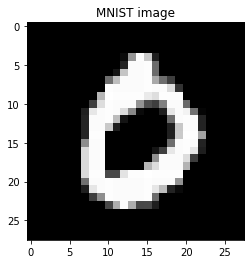

In [76]:
spikes, image = next(iter(testingSet))
plt.imshow(image.squeeze(), cmap='gray')
plt.title('MNIST image')
plt.show()

In [77]:
xspikes = spikes.to(device).unsqueeze(0)
newnet = newnet.to(device)
output = newnet(xspikes)

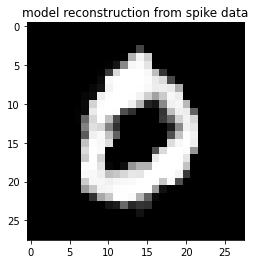

In [78]:
im = output.sum(dim=4).squeeze().cpu().detach()
plt.imshow(torch.sigmoid(im/10-3.5), cmap='gray')
plt.title('model reconstruction from spike data')
plt.show()

## visualize model parameters

In [79]:
layerkernels = []
for module in net.modules():
    if isinstance(module, snn.slayer._convLayer):
        layerkernels.append(module._parameters['weight'].cpu().detach().numpy())

In [80]:
def plotLayerKernels(layernum):
    kernels = layerkernels[layernum].squeeze(-1)
    cols = kernels.shape[0]
    rows = kernels.shape[1]
    
    scale = 1#np.sqrt(cols*rows*10)
    fig = plt.figure(figsize=(cols*scale, rows*scale))
#     fig.set_aspect(cols/rows)
    ax = fig.add_subplot(111, frameon=False)
    ax.set_title('kernels for layer {}'.format(layernum))
    ax.set_xlabel('output feature')
    ax.set_ylabel('input feature')
    ax.set_xticks([])
    ax.set_yticks([])
#     fig.text(0.5, 1/rows, 'output feature', ha='center', va='center')
#     fig.text(1/cols, 0.5, 'input feature', ha='center', va='center', rotation='vertical')

    for i in range(cols):
        for j in range(rows):
            kernel = kernels[i,j]
            kernel = kernel - kernel.min()
            kernel = kernel/kernel.max()
    #         z = np.zeros((kernel.shape[1], kernel.shape[2], 3))
    #         z[:, :, ::2] = kernel.transpose(1, 2, 0) # broadcast into r & b channels
            ax1 = fig.add_subplot(rows, cols, i*rows+j+1)
            ax1.imshow(kernel, cmap='gray')
            ax1.axis('off')
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    return fig

In [81]:
os.makedirs('plots/kernels/000')
for i in range(len(layerkernels)):
    plotLayerKernels(i).savefig('plots/kernels/000/{}'.format(i))

FileExistsError: [Errno 17] File exists: 'plots/kernels/000'